In [38]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
from itertools import islice 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import glob
import sys
sys.path.insert(0, "/data/u934/service_imagerie/v_kapoor/anaconda2/bin/PyImage/utils")
from tifffile import imread
from csbdeep.utils import Path, normalize
from skimage.segmentation import find_boundaries
from csbdeep.io import save_tiff_imagej_compatible
from stardist import dist_to_coord, non_maximum_suppression, polygons_to_label
from stardist import random_label_cmap, draw_polygons, sample_points,fill_label_holes
from stardist import Config, StarDist
import skimage
import scipy
from Normalize import Path,normalizeMinMax, fill_label_holes, save_tiff_imagej_compatible
from skimage import measure
from skimage import filters
from skimage.morphology import remove_small_objects
from skimage.filters import threshold_otsu
from skimage.exposure import rescale_intensity
from scipy import ndimage
np.random.seed(6)
lbl_cmap = random_label_cmap()

In [39]:
basedir = '/data/u934/service_imagerie/v_kapoor/HEARD/UNet-training/test3D/'
basedirResultsWithoutShape = '/data/u934/service_imagerie/v_kapoor/HEARD/UNet-training/results3D/'
ModelNameWithShape = 'StemCellWithShapeCompletion'
BaseDirModels = 'models'

In [40]:
Path = os.path.join(basedir, '*.tif')
X = []

Names = []

filesRaw = glob.glob(Path)
maxtime = 0
for fname in filesRaw:
     x = imread(fname)
     X.append(x)
     Names.append(fname)
      
X.sort
Names.sort
axes = 'TYX'
thresh = 0.4
nrays = 32
print('Total number of images to be segmented = ', len(X))
print('Image size = ', X[0].shape)
print('Time dim = ', maxtime )





Total number of images to be segmented =  1
Image size =  (73, 512, 512)
Time dim =  0


In [41]:
model_no_sc = StarDist(None, name = ModelNameWithShape, basedir = BaseDirModels )

Loading network weights from 'weights_best.h5'.


In [42]:
def ApplyAll(model, img, timerange):
    for j in range(timerange):
      smallimg = img[j,:,:]
      smallprob, smalldist = model_no_sc.predict(smallimg)
      smallcoord = dist_to_coord(smalldist)
      smallpoints = non_maximum_suppression(smallcoord,smallprob,prob_thresh=thresh)
   
      smalllabels = polygons_to_label(smallcoord,smallprob,smallpoints)
      
  
      prob[j,:,:] = smallprob[:,:] 
      labels[j,:,:] = smalllabels[:,:]
      
      dist[j,:,:,:] = smalldist[:,:,:]
      coord[j,:,:,:,:] = smallcoord[:,:,:,:]

        
    return prob,labels,dist,coord

In [43]:

for i in range(0, len(X)):

 img = normalize(X[i],1,99.8)
 prob = np.array(img)
 labels = np.array(img)
 
 timerange = img.shape[0]
 dist = np.zeros((img.shape[0], img.shape[1] ,img.shape[2], nrays))
 coord = np.zeros((img.shape[0], img.shape[1] ,img.shape[2], 2 , nrays))
 ApplyAll(model_no_sc,img, timerange)   
 save_tiff_imagej_compatible((basedirResultsWithoutShape +'Star'+ os.path.basename(Names[i])) , prob, axes)
        


 

/data/u934/service_imagerie/v_kapoor/anaconda2/envs/tensorflowpy3pt5/lib/python3.5/site-packages/csbdeep/data/prepare.py:284: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[crop]


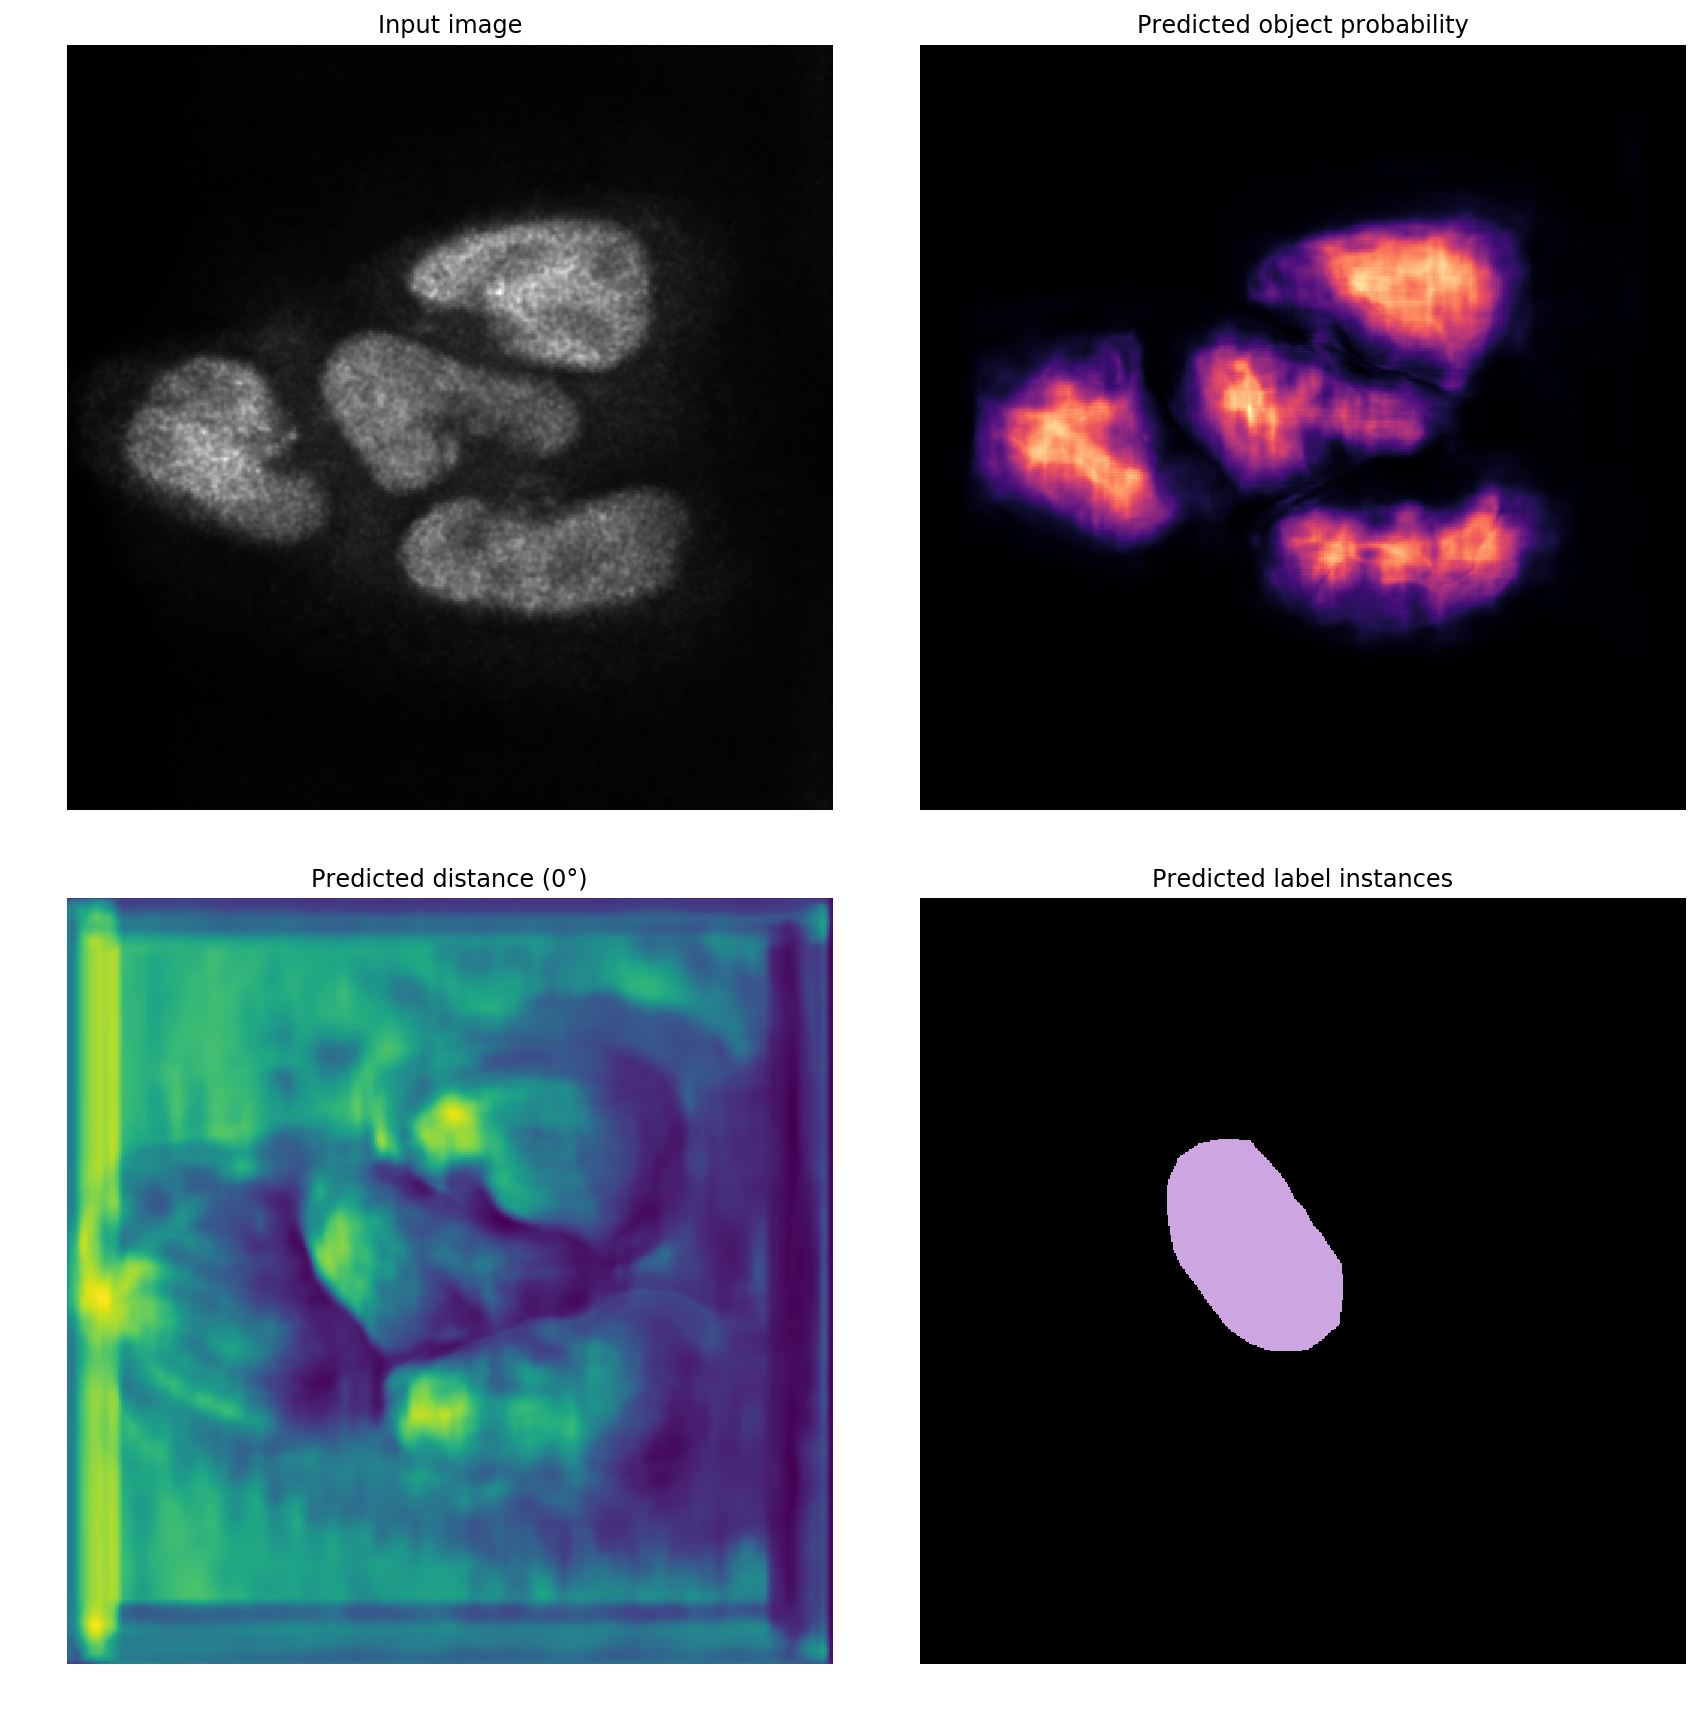

In [44]:
fig, ax = plt.subplots(2,2, figsize=(12,12))
timepoint = 0
imgtime = img[timepoint, :,:]
disttime = dist[timepoint, ...]
probtime = prob[timepoint, ...]
labelstime = labels[timepoint, ...]

for a,d,cm,s in zip(ax.flat, [imgtime,probtime,disttime[...,0],labelstime], ['gray','magma','viridis',lbl_cmap],
                    ['Input image','Predicted object probability','Predicted distance (0°)','Predicted label instances']):
    a.imshow(d,cmap=cm)
    a.set_title(s)
    a.axis('off')
plt.tight_layout()
None;